In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
%matplotlib inline

In [4]:
sess = tf.InteractiveSession()

In [22]:
# Parameters
learning_rate = 0.0001
#training_iters = 200000
batch_size = 200
display = 100

# Network Parameters
n_input = 128 
n_steps = 80 # timesteps,

n_hidden = 512 
n_classes = 2 

In [23]:
tf.reset_default_graph()
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'in': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'in' : tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [6]:
def rnn_cell():
    return rnn.BasicRNNCell(n_hidden, reuse=tf.get_variable_scope().reuse)

In [7]:
def gru_cell():
    return rnn.GRUCell(n_hidden, reuse=tf.get_variable_scope().reuse)

In [8]:
def lstm_cells():
    return rnn.LSTMCell(n_hidden, reuse=tf.get_variable_scope().reuse,  forget_bias=1.0)

In [24]:
def RNN_Model(x, weights, biases, kind, hidden_layer):

   
    x_or = x
    '''x = tf.reshape(x, [-1, n_input])
    x_in = tf.matmul(x, weights['in'] +biases['in'])
    x_in = tf.reshape(x_in, [-1,n_steps, n_hidden])
    x = tf.unstack(x_in, n_steps, 1)'''
    
    if(kind == 'LSTM'): 
        stacked_cell = rnn.MultiRNNCell([lstm_cells() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    if(kind == 'GRU'):
        stacked_cell = rnn.MultiRNNCell([gru_cell() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    else:
        stacked_cell = rnn.MultiRNNCell([rnn_cell() for _ in range(hidden_layer)] , state_is_tuple=True ) #add
    
    init_state = stacked_cell.zero_state(batch_size, tf.float32)
   
    outputs = []
    state = init_state
    with tf.variable_scope("RNN"):
        for time_step in range(n_steps):
            if time_step > 0: tf.get_variable_scope().reuse_variables()
            (cell_output, state) = stacked_cell(x[:, time_step, :], state)
            outputs.append(cell_output)


    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [25]:
pred = RNN_Model(x, weights, biases, 'RNN', 1) # GRU ,LSTM , default: RNN

##  Load Data

In [11]:
data_set = np.load('imdb_word_emb.npz')
X_train = data_set['X_train']
y_train = data_set['y_train']
X_test = data_set['X_test']
y_test = data_set['y_test']

In [12]:
y_convert = []
for i in y_train:
    if i == 0:
        ans = np.array([1.0, 0.0])
    else:
        ans = np.array([0.0, 1.0])
    y_convert.append(ans)
y_c = np.array(y_convert)

In [13]:
y_convert_test = []
for i in y_test:
    if i == 0:
        ans = np.array([1.0, 0.0])
    else:
        ans = np.array([0.0, 1.0])
    y_convert_test.append(ans)
yct = np.array(y_convert_test)

In [14]:
def random():
    
    num = len(X_train)
    idx = np.random.choice(num, size = batch_size, replace=False)
    
    x_batch = X_train[idx, :]
    y_batch = y_c[idx, :]

    return x_batch, y_batch

In [27]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))


#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cost)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables


In [16]:
def running():
    acc_test = 0.0 
    accuracy_train = []
    accuracy_test = []
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        step = 1
        while(1):
            if acc_test< 0.9:
                batch_x, batch_y = random()

                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
                if step % display == 0:

                    acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
                    accuracy_train.append(acc)

                    loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
                    print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + \
                          "{:.5f}".format(acc))
                    dx = 0
                    acc = []
                    for i in range(len(y_test)//batch_size):

                        test_data = X_test[dx:dx+batch_size]
                        test_label = yct[dx:dx+batch_size]
                        dx = dx+batch_size
                        acc.append(sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

                    acc_test =  np.mean(acc)
                    accuracy_test.append(acc_test)

                    print("Testing Accuracy:", \
                        accuracy_test)
                step += 1
            else:
                break
        print("Optimization Finished!")
    
    return accuracy_train, accuracy_test
    

In [17]:
LSTM_train, LSTM_test = running() 

Iter 20000, Minibatch Loss= 0.435844, Training Accuracy= 0.84500
Testing Accuracy: [0.85684001]
Iter 40000, Minibatch Loss= 0.314465, Training Accuracy= 0.89000
Testing Accuracy: [0.85684001, 0.87476009]
Iter 60000, Minibatch Loss= 0.314584, Training Accuracy= 0.88000
Testing Accuracy: [0.85684001, 0.87476009, 0.88432008]
Iter 80000, Minibatch Loss= 0.346795, Training Accuracy= 0.87500
Testing Accuracy: [0.85684001, 0.87476009, 0.88432008, 0.89024001]
Iter 100000, Minibatch Loss= 0.314469, Training Accuracy= 0.90500
Testing Accuracy: [0.85684001, 0.87476009, 0.88432008, 0.89024001, 0.88899994]
Iter 120000, Minibatch Loss= 0.281199, Training Accuracy= 0.90000
Testing Accuracy: [0.85684001, 0.87476009, 0.88432008, 0.89024001, 0.88899994, 0.89412004]
Iter 140000, Minibatch Loss= 0.296774, Training Accuracy= 0.88000
Testing Accuracy: [0.85684001, 0.87476009, 0.88432008, 0.89024001, 0.88899994, 0.89412004, 0.90287995]
Optimization Finished!


In [19]:
GRU_train, GRU_test = running()

Iter 20000, Minibatch Loss= 0.354374, Training Accuracy= 0.86500
Testing Accuracy: [0.84536004]
Iter 40000, Minibatch Loss= 0.408144, Training Accuracy= 0.85000
Testing Accuracy: [0.84536004, 0.87128001]
Iter 60000, Minibatch Loss= 0.221758, Training Accuracy= 0.92500
Testing Accuracy: [0.84536004, 0.87128001, 0.88300008]
Iter 80000, Minibatch Loss= 0.382105, Training Accuracy= 0.85000
Testing Accuracy: [0.84536004, 0.87128001, 0.88300008, 0.88971996]
Iter 100000, Minibatch Loss= 0.215279, Training Accuracy= 0.93000
Testing Accuracy: [0.84536004, 0.87128001, 0.88300008, 0.88971996, 0.89547998]
Iter 120000, Minibatch Loss= 0.253932, Training Accuracy= 0.90000
Testing Accuracy: [0.84536004, 0.87128001, 0.88300008, 0.88971996, 0.89547998, 0.89788008]
Iter 140000, Minibatch Loss= 0.181696, Training Accuracy= 0.92500
Testing Accuracy: [0.84536004, 0.87128001, 0.88300008, 0.88971996, 0.89547998, 0.89788008, 0.9034]
Optimization Finished!


In [28]:
basic_train, basic_test = running()

Iter 20000, Minibatch Loss= 0.367900, Training Accuracy= 0.83000
Testing Accuracy: [0.84347999]
Iter 40000, Minibatch Loss= 0.242934, Training Accuracy= 0.91500
Testing Accuracy: [0.84347999, 0.87484002]
Iter 60000, Minibatch Loss= 0.257583, Training Accuracy= 0.90500
Testing Accuracy: [0.84347999, 0.87484002, 0.88632011]
Iter 80000, Minibatch Loss= 0.319663, Training Accuracy= 0.87500
Testing Accuracy: [0.84347999, 0.87484002, 0.88632011, 0.89019996]
Iter 100000, Minibatch Loss= 0.250398, Training Accuracy= 0.91500
Testing Accuracy: [0.84347999, 0.87484002, 0.88632011, 0.89019996, 0.89836001]
Iter 120000, Minibatch Loss= 0.251924, Training Accuracy= 0.91000
Testing Accuracy: [0.84347999, 0.87484002, 0.88632011, 0.89019996, 0.89836001, 0.89975995]
Iter 140000, Minibatch Loss= 0.230903, Training Accuracy= 0.89500
Testing Accuracy: [0.84347999, 0.87484002, 0.88632011, 0.89019996, 0.89836001, 0.89975995, 0.89911997]
Iter 160000, Minibatch Loss= 0.206630, Training Accuracy= 0.92500
Testing

In [41]:
def plot_accuracy(train, test, word):
    
    
    for i in range(len(train)):
        train[i] = 1 - train[i]
    
    for i in range(len(test)):
        test[i] = 1 - test[i]
        
    plt.plot(range(len(basic_train)),basic_train,'b')
    plt.plot(range(len(basic_test)),basic_test,'r')
    plt.ylabel('Error rate')
    plt.title(word)
    plt.show()

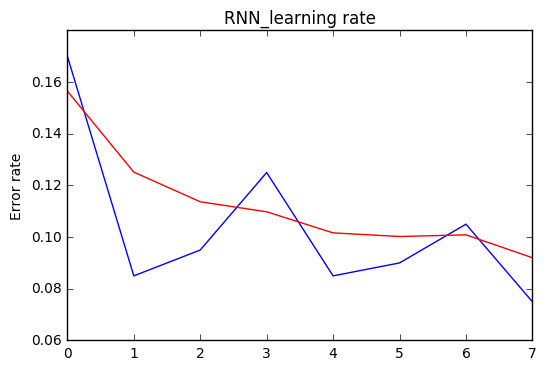

In [47]:
plot_accuracy(basic_train, basic_test, 'RNN_learning rate')

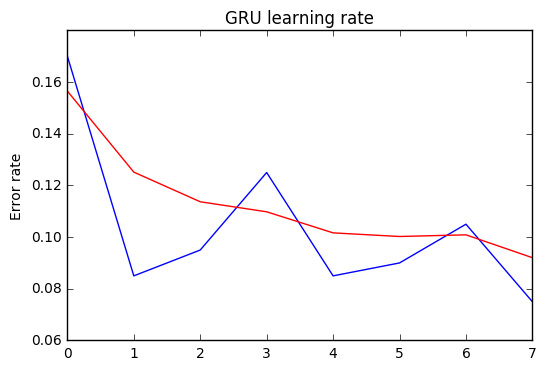

In [44]:
plot_accuracy(GRU_train, GRU_test, 'GRU learning rate')

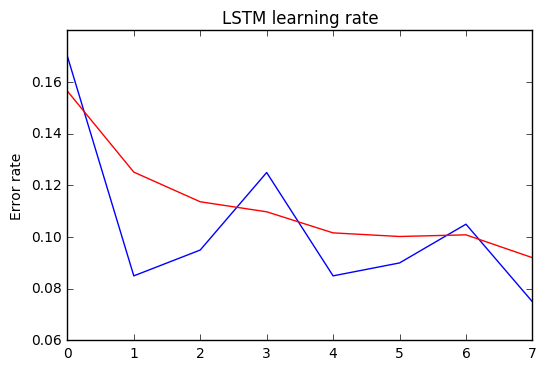

In [45]:
plot_accuracy(LSTM_train, LSTM_test, 'LSTM learning rate')